In [51]:
# Import all required libraries
import warnings
import pathlib
import sys

# Add src directory to path for helper functions
repo_dir = pathlib.Path().cwd().parent
src_dir = repo_dir / "src"
sys.path.insert(0, str(src_dir))

# Data manipulation and scientific computing
import pandas as pd
import numpy as np
import scipy.sparse

# Machine learning and neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Progress bars and utilities
from tqdm import tqdm

# Domain-specific libraries
import hetmatpy.matrix

# Import helper functions from src package
from models import EdgePredictionNN
from data_processing import prepare_edge_prediction_data, load_permutation_data, load_all_permutations
from training import train_edge_prediction_model, train_across_permutations
from visualization import (
    plot_training_history, 
    evaluate_model_performance, 
    create_probability_heatmap,
    plot_permutation_comparison
)

In [54]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
                                           # Example alternatives: 'hetio200' (downloaded), 'permutations/hetio200'

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")

Using permutations subdirectory: permutations


In [55]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / 'data'

# Use the parameterized permutations subdirectory
if '/' in permutations_subdirectory:
    # Handle nested paths like 'permutations/hetio200'
    permutations_dir = data_dir / permutations_subdirectory
elif permutations_subdirectory == 'permutations':
    # Handle the default case where we want data/permutations
    permutations_dir = data_dir / 'permutations'
else:
    # Handle other subdirectories like 'hetio200' -> data/permutations/hetio200
    permutations_dir = data_dir / 'permutations' / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {available_permutations}")
else:
    print(f"⚠️ Permutations directory not found: {permutations_dir}")
    available_permutations = []

Repository directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn
Data directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data
Permutations directory: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations
Available permutations: ['000.hetmat.bak', '001.hetmat', '000.hetmat']


In [ ]:
# Load and combine data from all available permutations
if available_permutations:
    print("Loading all available permutations...")
    all_perm_data = load_all_permutations(available_permutations, permutations_dir)
    print(f"\nSuccessfully loaded {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")
    
    if not all_perm_data:
        raise ValueError("No permutations were successfully loaded!")
    
    # Combine AeG matrices from all permutations
    print("\n" + "="*60)
    print("COMBINING AeG MATRICES FROM ALL PERMUTATIONS")
    print("="*60)
    
    combined_aeg_edges = []
    combined_anatomy_nodes = None
    combined_gene_nodes = None
    permutation_labels = []
    
    for perm_name, perm_data in all_perm_data.items():
        aeg_edges = perm_data['aeg_edges']
        anatomy_nodes = perm_data['anatomy_nodes']
        gene_nodes = perm_data['gene_nodes']
        
        print(f"Processing {perm_name}: {aeg_edges.shape} matrix with {aeg_edges.nnz} edges")
        
        # Store the AeG matrix
        combined_aeg_edges.append(aeg_edges)
        
        # Use node information from first permutation (should be consistent across permutations)
        if combined_anatomy_nodes is None:
            combined_anatomy_nodes = anatomy_nodes
            combined_gene_nodes = gene_nodes
            print(f"Using node definitions from {perm_name}")
            print(f"  Anatomy nodes: {len(anatomy_nodes)}")
            print(f"  Gene nodes: {len(gene_nodes)}")
        
        # Track which permutation each edge comes from
        permutation_labels.extend([perm_name] * aeg_edges.nnz)
    
    print(f"\nCombined data summary:")
    print(f"  Total permutations: {len(combined_aeg_edges)}")
    print(f"  Total edges across all permutations: {len(permutation_labels)}")
    print(f"  Matrix dimensions: {combined_aeg_edges[0].shape}")
    
    # Store combined data for neural network training
    print(f"\nData successfully combined from {len(all_perm_data)} permutations")
    
else:
    print("No permutations found in the permutations directory!")

Loading example data from: 000.hetmat
Loading data from permutation: 000.hetmat
Permutation path: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/dwpc_rnn/data/permutations/000.hetmat
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']

DATA SUMMARY
AeG edges matrix shape: (402, 20945)
AeG edges density: 0.062519
Number of Anatomy nodes: 402
Number of Gene nodes: 20945

Sample Anatomy nodes:
   position      identifier                       name
0         0  UBERON:0000002             uterine cervix
1         1  UBERON:0000004                       nose
2         2  UBERON:0000006        islet of Langerhans
3         3  UBERON:0000007            pituitary gland
4         4  UBERON:0000010  peripheral nervous system

Sample Gene nodes:
   position  identifier      name
0

In [56]:
# Verify all libraries are available for neural network training
print("All required libraries successfully imported!")
print("Ready for combined permutation analysis and neural network training.")

All required libraries successfully imported!
Ready for combined permutation analysis and neural network training.


In [57]:
# Prepare combined training data from all permutations
print("="*60)
print("PREPARING COMBINED TRAINING DATA")
print("="*60)

# Combine features and labels from all permutations
all_features = []
all_labels = []
permutation_sources = []

for perm_name, perm_data in all_perm_data.items():
    print(f"\nProcessing permutation: {perm_name}")
    
    # Prepare edge prediction data for this permutation
    features, labels = prepare_edge_prediction_data(
        perm_data, 
        sample_negative_ratio=1.0
    )
    
    print(f"  Features shape: {features.shape}")
    print(f"  Positive examples: {np.sum(labels == 1)}")
    print(f"  Negative examples: {np.sum(labels == 0)}")
    
    # Add to combined dataset
    all_features.append(features)
    all_labels.append(labels)
    
    # Track which permutation each sample comes from
    permutation_sources.extend([perm_name] * len(labels))

# Combine all features and labels
combined_features = np.vstack(all_features)
combined_labels = np.concatenate(all_labels)

print(f"\n" + "="*60)
print("COMBINED DATASET SUMMARY")
print("="*60)
print(f"Total samples: {len(combined_labels)}")
print(f"Total positive examples: {np.sum(combined_labels == 1)}")
print(f"Total negative examples: {np.sum(combined_labels == 0)}")
print(f"Feature matrix shape: {combined_features.shape}")
print(f"Data from {len(all_perm_data)} permutations: {list(all_perm_data.keys())}")

# Analyze degree ranges across all permutations
print(f"\nDegree statistics across all permutations:")
print(f"Source degree range: {combined_features[:, 0].min():.1f} - {combined_features[:, 0].max():.1f}")
print(f"Target degree range: {combined_features[:, 1].min():.1f} - {combined_features[:, 1].max():.1f}")
print(f"Source degree mean: {combined_features[:, 0].mean():.2f} ± {combined_features[:, 0].std():.2f}")
print(f"Target degree mean: {combined_features[:, 1].mean():.2f} ± {combined_features[:, 1].std():.2f}")

PREPARING COMBINED TRAINING DATA

Processing permutation: 000.hetmat
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
  Features shape: (1052814, 2)
  Positive examples: 526407
  Negative examples: 526407

Processing permutation: 001.hetmat
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of negative examples (non-existing edges): 526407
  Features shape: (1052814, 2)
  Positive examples: 526407
  Negative examples: 526407

Processing permutation: 001.hetmat
Anatomy degree range: 0 - 15036
Gene degree range: 0 - 98
Number of positive examples (existing edges): 526407
Number of positive examples (existing edges): 526407
Number of negative examples (non-existing edges): 526407
  Features shape: (1052814, 2)
  Positive examples: 526407
  Negative examples: 526407

COMBINED DATASET SUMMARY
Total samples: 


TRAINING NEURAL NETWORK ON COMBINED DATASET
Training neural network on combined permutation data...
Training on 1684502 samples, testing on 421126 samples
Feature shapes: (1684502, 2), Labels shape: (1684502,)
Training on 1684502 samples, testing on 421126 samples
Feature shapes: (1684502, 2), Labels shape: (1684502,)


Training:  67%|██████▋   | 20/30 [02:32<01:16,  7.63s/it]

Epoch 20/30: Train Loss: 0.1303, Val Loss: 0.1294, Val AUC: 0.9876


Training: 100%|██████████| 30/30 [03:49<00:00,  7.65s/it]



Final Test AUC: 0.9877
Final Test AP: 0.9848

Training completed!
Final Test AUC: 0.9877
Final Test Average Precision: 0.9848

Plotting training history...


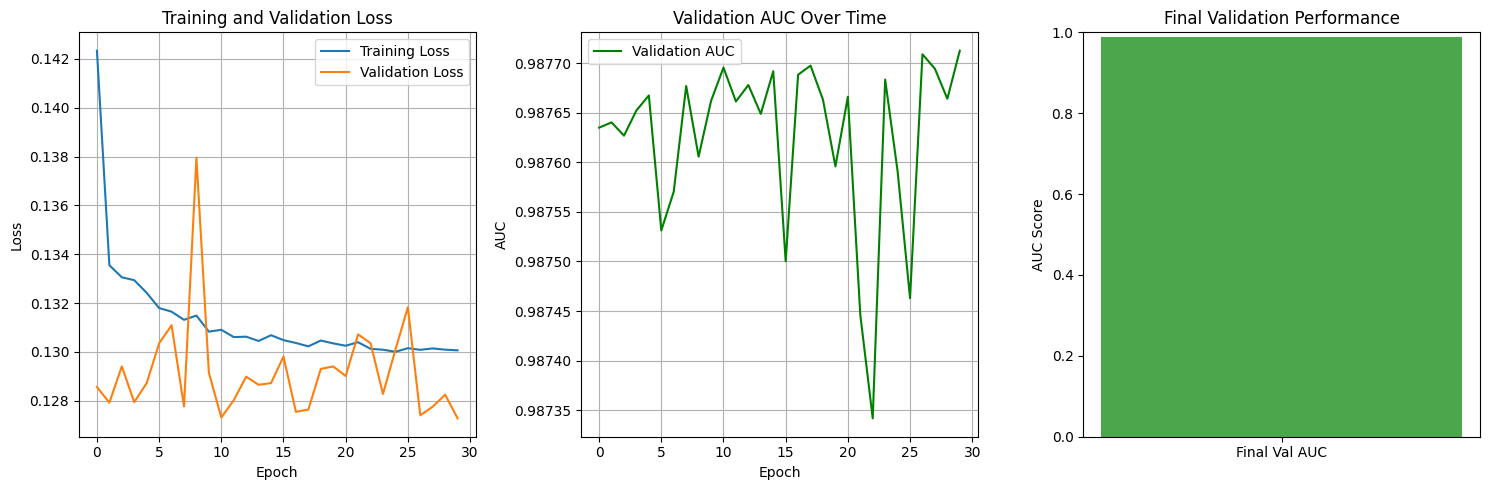


Evaluating model performance...
Test AUC: 0.9877
Average Precision: 0.9848


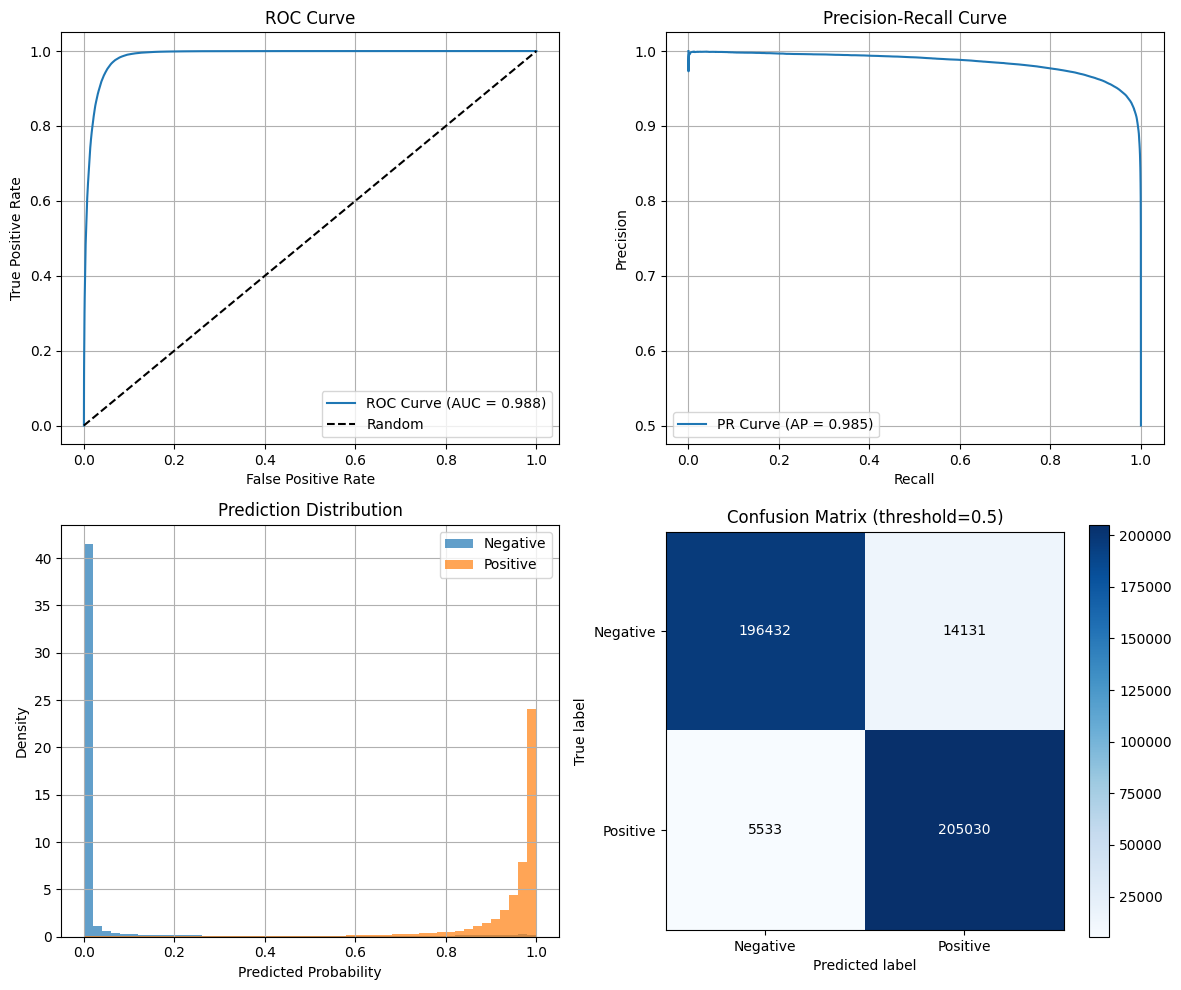

In [59]:
# Train neural network on combined dataset
print("\n" + "="*60)
print("TRAINING NEURAL NETWORK ON COMBINED DATASET")
print("="*60)

# Train the model on combined data
print("Training neural network on combined permutation data...")
model, train_history, test_metrics = train_edge_prediction_model(
    combined_features, combined_labels, 
    epochs=30,  # More epochs for larger, more complex dataset
    batch_size=1024,  # Larger batch size for combined data
    learning_rate=0.001
)

print(f"\nTraining completed!")
print(f"Final Test AUC: {test_metrics['auc']:.4f}")
print(f"Final Test Average Precision: {test_metrics['average_precision']:.4f}")

# Visualize training results
print("\nPlotting training history...")
plot_training_history(train_history)

print("\nEvaluating model performance...")
threshold_results = evaluate_model_performance(test_metrics)


PROBABILITY HEATMAP ANALYSIS
Creating probability heatmap...
Source degree range: 0.0 - 15036.0
Target degree range: 0.0 - 98.0


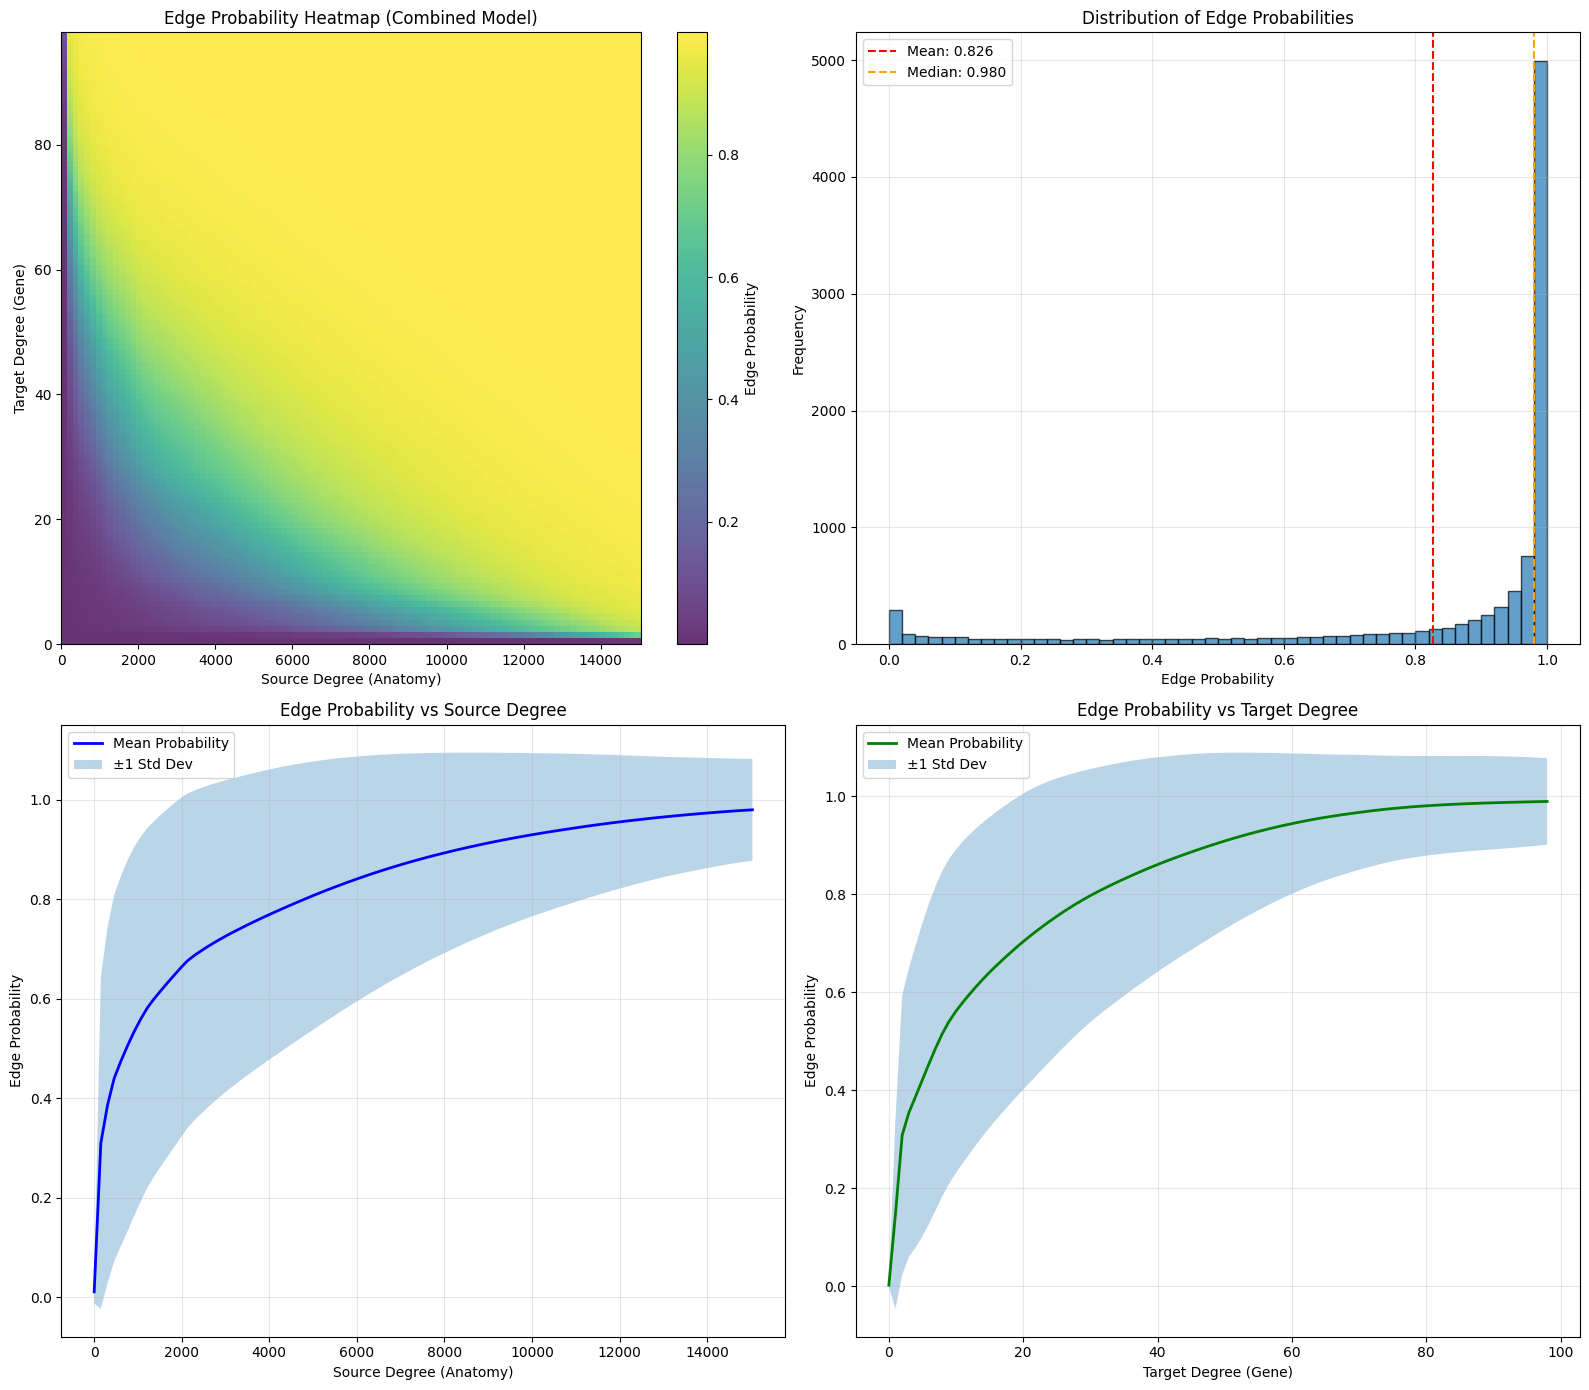


Summary Statistics:
Overall probability range: 0.0000 - 1.0000
Mean probability: 0.8262 ± 0.2888
Median probability: 0.9798

High probability regions (>95th percentile, >1.000):
  Source degree: 15036.0, Target degree: 70.3, Probability: 0.9999
  Source degree: 14884.1, Target degree: 71.3, Probability: 0.9999
  Source degree: 15036.0, Target degree: 71.3, Probability: 0.9999
  Source degree: 14732.2, Target degree: 72.3, Probability: 0.9999
  Source degree: 14884.1, Target degree: 72.3, Probability: 0.9999

Low probability regions (<5th percentile, <0.073):
  Source degree: 0.0, Target degree: 0.0, Probability: 0.0000
  Source degree: 151.9, Target degree: 0.0, Probability: 0.0000
  Source degree: 303.8, Target degree: 0.0, Probability: 0.0000
  Source degree: 455.6, Target degree: 0.0, Probability: 0.0000
  Source degree: 607.5, Target degree: 0.0, Probability: 0.0000


In [61]:
# Create probability heatmap for combined model
print("\n" + "="*60)
print("PROBABILITY HEATMAP ANALYSIS")
print("="*60)

# Use the scaler from the trained model
scaler = test_metrics['scaler']

# Determine degree ranges from combined data
source_degrees = np.linspace(
    combined_features[:, 0].min(), 
    combined_features[:, 0].max(), 
    100
)
target_degrees = np.linspace(
    combined_features[:, 1].min(), 
    combined_features[:, 1].max(), 
    100
)

print(f"Creating probability heatmap...")
print(f"Source degree range: {source_degrees.min():.1f} - {source_degrees.max():.1f}")
print(f"Target degree range: {target_degrees.min():.1f} - {target_degrees.max():.1f}")

# Create probability heatmap - unpack the returned tuple properly
probability_matrix, _, _ = create_probability_heatmap(
    model, scaler, source_degrees, target_degrees, resolution=100
)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Main probability heatmap
im1 = axes[0, 0].imshow(probability_matrix, 
                       extent=[source_degrees.min(), source_degrees.max(), 
                              target_degrees.min(), target_degrees.max()],
                       origin='lower', aspect='auto', cmap='viridis', alpha=0.8)

axes[0, 0].set_xlabel('Source Degree (Anatomy)')
axes[0, 0].set_ylabel('Target Degree (Gene)')
axes[0, 0].set_title('Edge Probability Heatmap (Combined Model)')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0, 0])
cbar1.set_label('Edge Probability')

# 2. Probability distribution histogram
axes[0, 1].hist(probability_matrix.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Edge Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Edge Probabilities')
axes[0, 1].grid(True, alpha=0.3)

# Add summary statistics
mean_prob = probability_matrix.mean()
median_prob = np.median(probability_matrix)
axes[0, 1].axvline(mean_prob, color='red', linestyle='--', label=f'Mean: {mean_prob:.3f}')
axes[0, 1].axvline(median_prob, color='orange', linestyle='--', label=f'Median: {median_prob:.3f}')
axes[0, 1].legend()

# 3. Probability vs Source Degree (averaged over target degrees)
mean_prob_by_source = probability_matrix.mean(axis=0)
std_prob_by_source = probability_matrix.std(axis=0)
axes[1, 0].plot(source_degrees, mean_prob_by_source, 'b-', linewidth=2, label='Mean Probability')
axes[1, 0].fill_between(source_degrees, 
                       mean_prob_by_source - std_prob_by_source,
                       mean_prob_by_source + std_prob_by_source, 
                       alpha=0.3, label='±1 Std Dev')
axes[1, 0].set_xlabel('Source Degree (Anatomy)')
axes[1, 0].set_ylabel('Edge Probability')
axes[1, 0].set_title('Edge Probability vs Source Degree')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Probability vs Target Degree (averaged over source degrees)
mean_prob_by_target = probability_matrix.mean(axis=1)
std_prob_by_target = probability_matrix.std(axis=1)
axes[1, 1].plot(target_degrees, mean_prob_by_target, 'g-', linewidth=2, label='Mean Probability')
axes[1, 1].fill_between(target_degrees, 
                       mean_prob_by_target - std_prob_by_target,
                       mean_prob_by_target + std_prob_by_target, 
                       alpha=0.3, label='±1 Std Dev')
axes[1, 1].set_xlabel('Target Degree (Gene)')
axes[1, 1].set_ylabel('Edge Probability')
axes[1, 1].set_title('Edge Probability vs Target Degree')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Overall probability range: {probability_matrix.min():.4f} - {probability_matrix.max():.4f}")
print(f"Mean probability: {probability_matrix.mean():.4f} ± {probability_matrix.std():.4f}")
print(f"Median probability: {np.median(probability_matrix):.4f}")

# Analyze high and low probability regions
high_prob_threshold = np.percentile(probability_matrix, 95)
low_prob_threshold = np.percentile(probability_matrix, 5)

print(f"\nHigh probability regions (>95th percentile, >{high_prob_threshold:.3f}):")
high_prob_mask = probability_matrix > high_prob_threshold
high_prob_indices = np.where(high_prob_mask)
if len(high_prob_indices[0]) > 0:
    for i in range(min(5, len(high_prob_indices[0]))):
        source_idx, target_idx = high_prob_indices[1][i], high_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")

print(f"\nLow probability regions (<5th percentile, <{low_prob_threshold:.3f}):")
low_prob_mask = probability_matrix < low_prob_threshold
low_prob_indices = np.where(low_prob_mask)
if len(low_prob_indices[0]) > 0:
    for i in range(min(5, len(low_prob_indices[0]))):
        source_idx, target_idx = low_prob_indices[1][i], low_prob_indices[0][i]
        prob_val = probability_matrix[target_idx, source_idx]
        print(f"  Source degree: {source_degrees[source_idx]:.1f}, Target degree: {target_degrees[target_idx]:.1f}, Probability: {prob_val:.4f}")


LOGISTIC REGRESSION BASELINE COMPARISON
Training logistic regression model...

Logistic Regression Results:
Train AUC: 0.9781
Test AUC: 0.9780
Train AP: 0.9751
Test AP: 0.9748

Neural Network Results (for comparison):
Test AUC: 0.9877
Test AP: 0.9848

Performance Difference (NN - LR):
AUC improvement: +0.0097 (+1.0%)
AP improvement: +0.0100 (+1.0%)


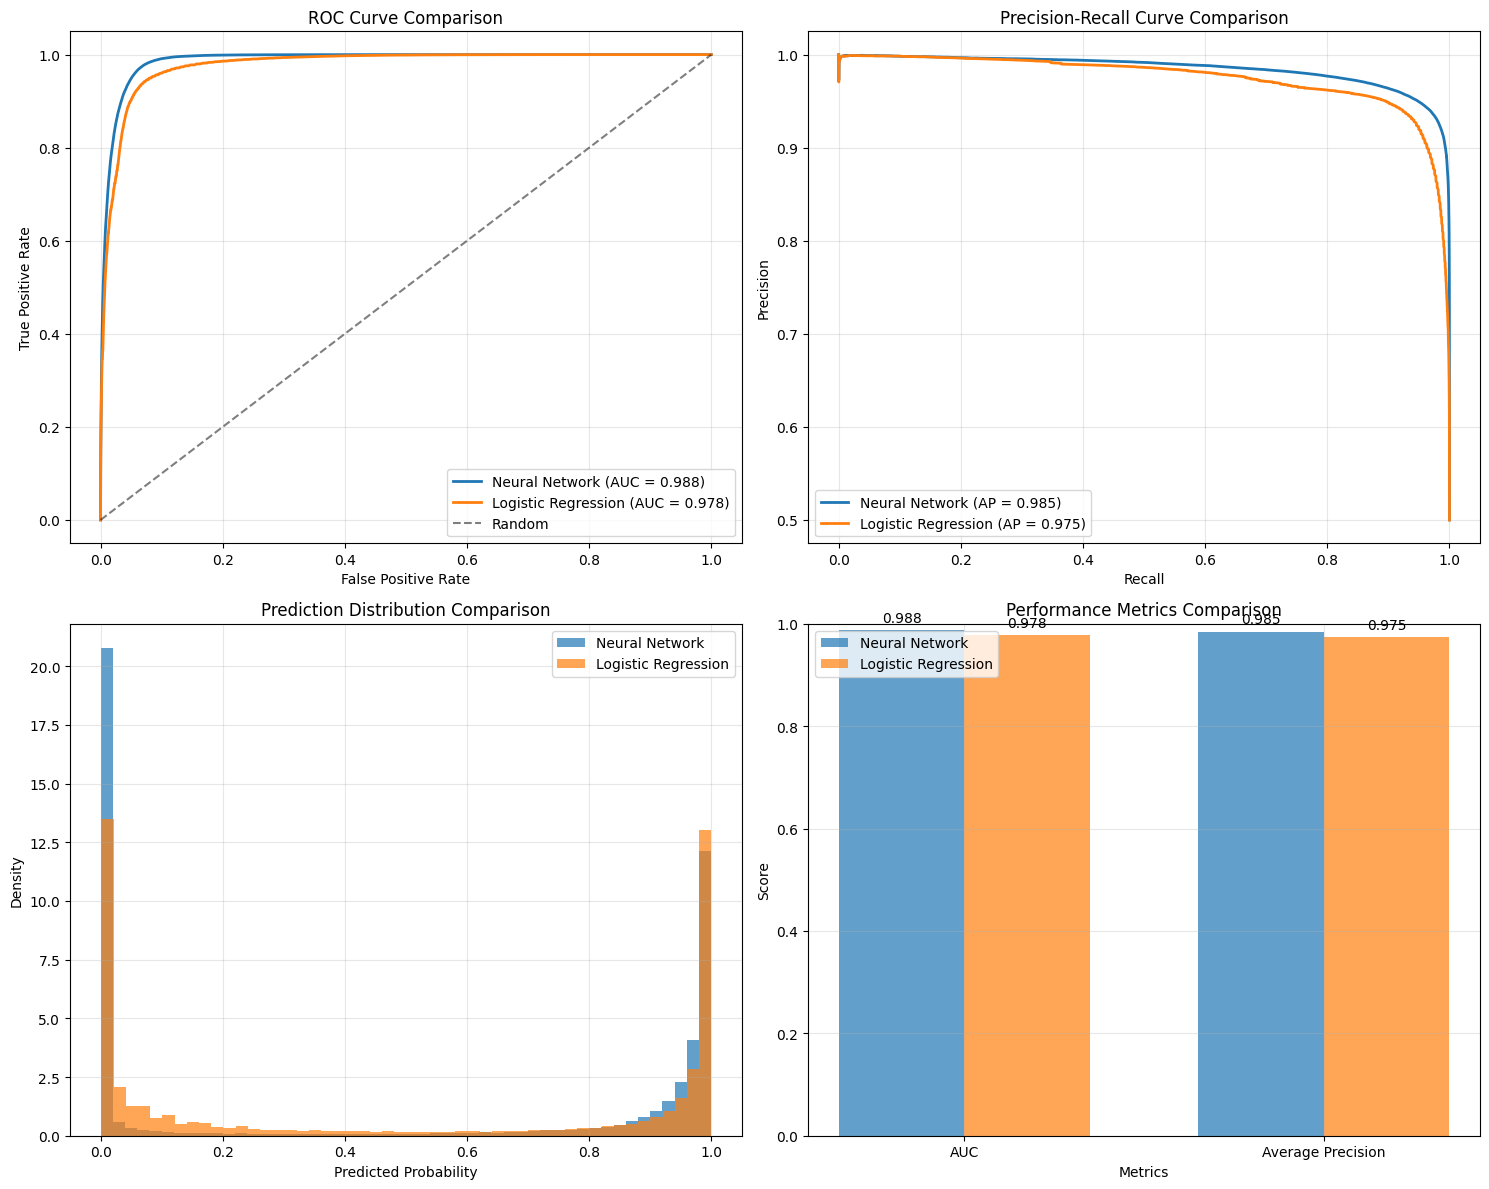


Logistic Regression Coefficients:
Source degree coefficient: 3.8311
Target degree coefficient: 1.9010
Intercept: 0.1400
→ Higher source degree increases edge probability
→ Higher target degree increases edge probability

🔄 Neural Network and Logistic Regression perform similarly
   The relationship appears to be primarily linear


In [62]:
# Compare with simple logistic regression baseline
print("\n" + "="*60)
print("LOGISTIC REGRESSION BASELINE COMPARISON")
print("="*60)

# Use the same train/test split as the neural network
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, combined_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=combined_labels
)

# Scale features for logistic regression (use same scaler as NN)
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

print("Training logistic regression model...")

# Train logistic regression with regularization
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0  # Regularization strength
)
lr_model.fit(X_train_scaled, y_train)

# Get predictions
lr_train_pred = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_pred = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
lr_train_auc = roc_auc_score(y_train, lr_train_pred)
lr_test_auc = roc_auc_score(y_test, lr_test_pred)
lr_train_ap = average_precision_score(y_train, lr_train_pred)
lr_test_ap = average_precision_score(y_test, lr_test_pred)

print(f"\nLogistic Regression Results:")
print(f"Train AUC: {lr_train_auc:.4f}")
print(f"Test AUC: {lr_test_auc:.4f}")
print(f"Train AP: {lr_train_ap:.4f}")
print(f"Test AP: {lr_test_ap:.4f}")

print(f"\nNeural Network Results (for comparison):")
print(f"Test AUC: {test_metrics['auc']:.4f}")
print(f"Test AP: {test_metrics['average_precision']:.4f}")

# Calculate performance differences
auc_diff = test_metrics['auc'] - lr_test_auc
ap_diff = test_metrics['average_precision'] - lr_test_ap

print(f"\nPerformance Difference (NN - LR):")
print(f"AUC improvement: {auc_diff:+.4f} ({auc_diff/lr_test_auc*100:+.1f}%)")
print(f"AP improvement: {ap_diff:+.4f} ({ap_diff/lr_test_ap*100:+.1f}%)")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curves comparison
nn_fpr, nn_tpr, _ = roc_curve(test_metrics['true_labels'], test_metrics['predictions'])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_test_pred)

axes[0, 0].plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {test_metrics["auc"]:.3f})', linewidth=2)
axes[0, 0].plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_test_auc:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curves comparison
nn_precision, nn_recall, _ = precision_recall_curve(test_metrics['true_labels'], test_metrics['predictions'])
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_test_pred)

axes[0, 1].plot(nn_recall, nn_precision, label=f'Neural Network (AP = {test_metrics["average_precision"]:.3f})', linewidth=2)
axes[0, 1].plot(lr_recall, lr_precision, label=f'Logistic Regression (AP = {lr_test_ap:.3f})', linewidth=2)
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction distribution comparison
axes[1, 0].hist(test_metrics['predictions'], bins=50, alpha=0.7, label='Neural Network', density=True)
axes[1, 0].hist(lr_test_pred, bins=50, alpha=0.7, label='Logistic Regression', density=True)
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Prediction Distribution Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Performance metrics bar chart
metrics = ['AUC', 'Average Precision']
nn_scores = [test_metrics['auc'], test_metrics['average_precision']]
lr_scores = [lr_test_auc, lr_test_ap]

x = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x - width/2, nn_scores, width, label='Neural Network', alpha=0.7)
axes[1, 1].bar(x + width/2, lr_scores, width, label='Logistic Regression', alpha=0.7)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance Metrics Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

# Add value labels on bars
for i, (nn_score, lr_score) in enumerate(zip(nn_scores, lr_scores)):
    axes[1, 1].text(i - width/2, nn_score + 0.01, f'{nn_score:.3f}', ha='center', va='bottom')
    axes[1, 1].text(i + width/2, lr_score + 0.01, f'{lr_score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analyze logistic regression coefficients
print(f"\nLogistic Regression Coefficients:")
print(f"Source degree coefficient: {lr_model.coef_[0][0]:.4f}")
print(f"Target degree coefficient: {lr_model.coef_[0][1]:.4f}")
print(f"Intercept: {lr_model.intercept_[0]:.4f}")

# Interpretation
if lr_model.coef_[0][0] > 0:
    print(f"→ Higher source degree increases edge probability")
else:
    print(f"→ Higher source degree decreases edge probability")

if lr_model.coef_[0][1] > 0:
    print(f"→ Higher target degree increases edge probability")
else:
    print(f"→ Higher target degree decreases edge probability")

# Statistical significance test (if the difference is meaningful)
if abs(auc_diff) > 0.01:  # Threshold for meaningful difference
    if auc_diff > 0:
        print(f"\n✅ Neural Network shows meaningful improvement over Logistic Regression")
        print(f"   The non-linear model captures patterns that linear regression misses")
    else:
        print(f"\n⚠️ Logistic Regression performs similarly or better than Neural Network")
        print(f"   The relationship might be primarily linear")
else:
    print(f"\n🔄 Neural Network and Logistic Regression perform similarly")
    print(f"   The relationship appears to be primarily linear")